In [39]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

In [94]:
datadir = "/home/ctroupin/Projects/RandoGC/Data/136_MDT25_GC/"
datafile = os.path.join(datadir, '136_MDT25_GC.tif')

In [98]:
def read_geotiff(filename):
    
    # Transform to lon, lat coordinates using WGS84
    command = 'gdalwarp {} outfile.tif -t_srs "+proj=longlat +ellps=WGS84"'.format(filename)
    # subprocess.call()
    subprocess.run(command, cwd=datadir, stdout=subprocess.PIPE, shell=True)
    ds = gdal.Open(os.path.join(datadir, 'outfile.tif'), gdal.GA_ReadOnly)

    ds.GetProjectionRef()

    # Read the array and the transformation
    array = ds.ReadAsArray()
    trans = ds.GetGeoTransform()
    extent = (trans[0], trans[0] + ds.RasterXSize*trans[1],
              trans[3] + ds.RasterYSize*trans[5], trans[3])

    x = np.arange(0, ds.RasterXSize)
    y = np.arange(0, ds.RasterYSize)
    xx, yy = np.meshgrid(x, y)

    lon = trans[1] * xx + trans[2] * yy + trans[0]
    lat = trans[4] * xx + trans[5] * yy + trans[3]
        
    return lon, lat, array

In [99]:
lon, lat, array = read_geotiff(datafile)

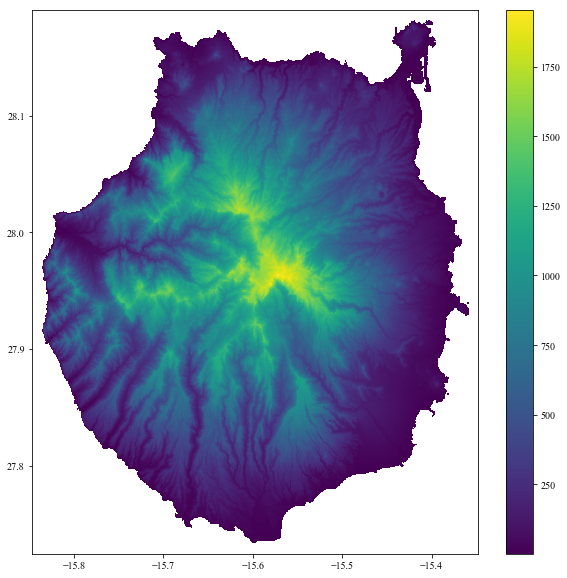

In [101]:
plt.figure(figsize=(10, 10))
array = np.ma.masked_less_equal(array, 0.)
plt.pcolormesh(lon, lat, array)
plt.colorbar()
plt.show()